In [2]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

xgboost的基本原理与实现简介
========================

xgboost是个很棒的工具，其优点很多：运行速度，支持正则，直接用损失函数指导树的生成等等，不一而足。相较spark自带的gbdt，xgboost更适合工程应用。

本文参照论文 Tianqi Chen and Carlos Guestrin. XGBoost: A Scalable Tree Boosting System，介绍下xgboost对原始gbdt的改进地方，并说明下具体的实现细节。

代码版本信息：

```bash
~/W/xgboost ❯❯❯ git log -n 1
commit 74db1e8867eb9ecfacf07311131c2724dbc3fdbd
Author: Nan Zhu <CodingCat@users.noreply.github.com>
Date:   Sun Aug 28 21:25:49 2016 -0400

    [jvm-packages] remove APIs with DMatrix from xgboost-spark  (#1519)

    * test consistency of prediction functions between DMatrix and RDD

    * remove APIs with DMatrix from xgboost-spark

    * fix compilation error in xgboost4j-example

    * fix test cases
```

### 0. 大纲

xgboost的贡献，既有理论上的拓展，也有工程上的性能优化。本文只关心在其在理论上的改进，主要是将正则（Regularized）引入损失函数，并且用损失函数直接指导树的生成。我们用传统GBDT做引，一步步走到xgboost。

这里假设读者已经了解决策树和GBDT的原理，不会过多铺垫。

### 1. GBDT框架

为了便于后续讲解，首先会引入公式描述决策树和GBDT模型，涉及的数学知识是比较简易的，不要恐慌。

对于一个$J$颗叶子的决策树（CART），可以表示为加法模型[1]：

\begin{equation}
    f(x) = h \left (x; \{b_j, R_j\}^J_1 \right ) = \displaystyle \sum_{j=1}^J b_j \mathbf{1}(x \in R_j)
\end{equation}

其中$R_j$是叶子，$b_j$是叶子对应的值。

对于一个tree ensemble model，就是$K$颗树的结果叠加：

\begin{equation}
    \hat{y}_i = \phi(x_i) = \displaystyle \sum_{k=1}^K f_k(x_i)
\end{equation}

具体到传统的GBDT，其可描述成最优问题：

\begin{align}
    f_m &= \displaystyle \operatorname{arg \, min}_f \sum_{i=1}^n L \left ( y_i, \hat{y}_i + f(x_i) \right ) \\
        &= \operatorname{arg \, min} \mathcal{L}(f)
\end{align}

传统的思路，便是借用最速下降的想法，认定损失函数中$f(x_i)$是关于梯度的一个函数。而xgboost正是在这里做了新的文章，引入正则，泰勒展开，再揉进树模型里。

[1]:  Friedman - Greedy function approximation: A gradient boosting machine

### 2. xgboost

#### 2.0 正则

xgboost将正则 $\Omega(f)$ 引入进损失函数 $\mathcal{L}(f)$，控制了树的叶子数$\|R_j\|$和叶子值$b_j$，表示如下： 

\begin{align}
    \mathcal{L}(f) &= \displaystyle \sum_{i=1}^{n} L(y_i, \hat{y}_i + f(x_i)) + \Omega(f) \\
    \Omega(f) &= \gamma \|R_j\| + \frac{1}{2} \lambda \|b_j\|^2
\end{align}

但这样纯理论的公式是无法应用到工程上的，要用它指导树模型的生成，必须将它的这两个加法项$\sum L(f)$和$\Omega(f)$整合，才可以直接指导模型生成。要整合，重点有两个，一是打开$\sum L(f)$，放出$f$；二是将$\mathcal{L}(f)$转换成指导树生长的函数。

#### 2.1 泰勒展开

对于第一个问题，打开 $\sum L(f)$，xgboost的方法是利用[泰勒展开](https://zh.wikipedia.org/wiki/泰勒公式)成二阶多项式:

\begin{align}
    \mathcal{L} &\approx \sum_{i=1}^n \left [ L(y_i, \hat{y}_i) + g_i f(x_i) + \frac{1}{2} h_i f^2(x_i) \right ] + \Omega(f) \\
    g_i &= \frac{\partial \, L(y_i, \hat{y}_i)}{\partial \hat{y}_i} \\
    h_i &= \frac{\partial^2 \, L(y_i, \hat{y}_i)}{\partial \hat{y}^2_i} \\
\end{align}

为了便于理解，我将推导过程细致说下：

利用泰勒公式，我们在单点可将一个函数$f(x)$展开为高阶导数的叠加： 
\begin{equation}
    \sum _{n=0}^{\infty }{\frac {f^{(n)}(a)}{n!}}(x-a)^{n}
\end{equation}

具体到二阶导数为
\begin{equation}
f(x) \approx f(a)+{\frac  {f'(a)}{1!}}(x-a)+{\frac  {f''(a)}{2!}}(x-a)^{2}
\end{equation}

我们做点变形以利于理解，令$t = \hat{y}_i + f(x_i)$，则
\begin{align}
    L(y_i, \hat{y}_i + f(x_i)) &= L(y_i, t)\\
                               &= L(t) \quad \text{给定$x_i$，则$y_i$是定值，即常数}
\end{align}

接着利用泰勒将$L(t)$在$\hat{y}_i$点展开：

\begin{align}
L(t) &\approx L(\hat{y}_i) + {\frac  {L'(\hat{y}_i)}{1!}}(t-\hat{y}_i)+{\frac  {f''(\hat{y}_i)}{2!}}(t-\hat{y}_i)^{2} \\
     &= L(\hat{y}_i) + L'(\hat{y}_i) f(x_i) + \frac{1}{2}f''(\hat{y}_i) f^{2}(x_i) \\
     &= L(y_i, \hat{y}_i) + L'(\hat{y}_i) f(x_i) + \frac{1}{2}f''(\hat{y}_i) f^{2}(x_i) \\
     &= L(y_i, \hat{y}_i) + g_i f(x_i) + \frac{1}{2} h_i f^2(x_i) 
\end{align}

#### 2.2 引入树模型

泰勒解决了第一个问题，打开$L(f)$，得到：

\begin{equation}
    \mathcal{L} \approx \sum_{i=1}^n \left [ L(y_i, \hat{y}_i) + g_i f(x_i) + \frac{1}{2} h_i f^2(x_i) \right ] + \Omega(f)
\end{equation}

接着需要回答第二个问题，在这之前，我们先做点预处理。

对于损失函数$\mathcal{L}$，常数项$L(y_i, \hat{y}_i)$是可以直接舍掉的，记为： 

\begin{equation}
    \mathcal{L} = \sum_{i=1}^n \left [ g_i f(x_i) + \frac{1}{2} h_i f^2(x_i) \right ] + \Omega(f)
\end{equation}

如何用这个外部的损失函数指导树模型呢？

在论文Friedman - Greedy function approximation: A gradient boosting machine里推导TreeBoost方法时给了个套路：

1. 将决策树的数学模型$f(x)$代入外部损失函数$\mathcal{L}$。
2. 固定$J$，得到最优的$b_j$解析式。
3. 反代$b_j$回$\mathcal{L}$，将它作为树生成的评价函数（内部损失函数）。

这个套路的思想是，对于树模型来说，主要有两个参数：叶子数、叶子值。通过固定叶子数，就可以利用外部损失函数$\mathcal{L}(f)$寻优到最佳的叶子值计算解析式。将参数反代，外部损失函数就变成只和$x$相关$\mathcal{L}(x)$，这时它就可以作为树生长的评价函数。这个思路挺巧妙的，可能有点绕。


##### 2.2.0 代入树模型

我们就将树模型$f(x)$的数学代入，

\begin{align}
    \mathcal{L} &= \sum_{i=1}^n \left [ g_i f(x_i) + \frac{1}{2} h_i f^2(x_i) \right ] + \Omega(f) \\
                &= \sum_{i=1}^n \left [ g_i \sum_{j=1}^J b_j \mathbf{1}(x_i \in R_j) + \frac{1}{2} h_i (\sum_{j=1}^J \color{red}{b_j} \mathbf{1}(x_i \in R_j))^{\color{red}{2}} \right ] + \Omega(f) \\  
                &= \sum_{i=1}^n \left [ g_i \sum_{j=1}^J b_j \mathbf{1}(x_i \in R_j) + \frac{1}{2} h_i \sum_{j=1}^J \color{red}{b_j^2} \mathbf{1}(x_i \in R_j) \right ] + \Omega(f) \quad \text{因为$x_i$只属于一个$R_j$} \\
                &= \sum_{j=1}^J \color{blue}{\sum_{i=1}^n \mathbf{1}(x_i \in R_j)} g_i b_j + \frac{1}{2} \color{blue}{\sum_{j=1}^J \sum_{i=1}^n \mathbf{1}(x_i \in R_j)} h_i b_j^2 + \Omega(f) \quad \text{乘法交换} \\
                &\text{令} I_j = \{ i \, | \, x_i \in R_j \} \quad \text{即属于$R_j$的全部下标$i$} \\
                &= \sum_{j=1}^J \color{blue}{\sum_{i \in I_j}} g_i b_j + \frac{1}{2} \sum_{j=1}^J \color{blue}{\sum_{i \in I_j}} h_i b_j^2 + \Omega(f) \\
                &= \sum_{j=1}^J ( \sum_{i \in I_j} g_i ) b_j + \frac{1}{2} \sum_{j=1}^J (\sum_{i \in I_j} h_i) b_j^2 + \Omega(f) \quad \text{乘法分配律}\\
                &= \sum_{j=1}^J ( \sum_{i \in I_j} g_i ) b_j + \frac{1}{2} \sum_{j=1}^J (\sum_{i \in I_j} h_i) b_j^2 + \gamma \|R_j\| + \frac{1}{2} \lambda \|b_j\|^2 \quad \text{代入正则$\Omega(f)$}\\
                &= \sum_{j=1}^J ( \sum_{i \in I_j} g_i ) b_j + \frac{1}{2} \sum_{j=1}^J (\sum_{i \in I_j} h_i) b_j^2 + \gamma \|R_j\| + \frac{1}{2} \lambda \sum_{j=1}^J b_j^2 \\
                &= \sum_{j=1}^J \left ( ( \sum_{i \in I_j} g_i ) b_j + \frac{1}{2} (\sum_{i \in I_j} h_i) b_j^2 + \frac{1}{2} \lambda b_j^2 \right ) + \gamma \|R_j\|  \\
                &= \sum_{j=1}^J \left ( ( \sum_{i \in I_j} g_i ) b_j + \frac{1}{2} (\sum_{i \in I_j} h_i + \lambda) b_j^2 \right ) + \gamma \|R_j\|  \\
\end{align}

##### 2.2.1 $b_j$最优解析式

\begin{align}
    b_j &= \operatorname{arg \, min}_{b_j} \mathcal{L} \\
        &= \operatorname{arg \, min}_{b_j} \sum_{j=1}^J \left ( ( \sum_{i \in I_j} g_i ) b_j + \frac{1}{2} (\sum_{i \in I_j} h_i + \lambda) b_j^2 \right ) + \gamma \|R_j\|  \\
        &\approx \sum_{j=1}^J \operatorname{arg \, min}_{b_j} \left ( ( \sum_{i \in I_j} g_i ) \color{red}{b_j} + \frac{1}{2} (\sum_{i \in I_j} h_i + \lambda) \color{red}{b_j^2} \right ) + \gamma \|R_j\| 
\end{align}

全局最优不好求，我们转而求局部最优。注意到每个局部项是一个二项式，它的最小点可用公式直接套出：

\begin{align}
    b^*_j &= - \frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda} \\
\end{align}

##### 2.2.2 树生长的评价函数

将$b_j$重代回$\mathcal{L}$得到评价函数：

\begin{align}
    \mathcal{L} &= - \frac{1}{2} \sum_{j=1}^J \frac{(\sum_{i \in I_j} g_i)^2}{\sum_{i \in I_j} h_i + \lambda} + \gamma \|R_j\| \\
                &= - \frac{1}{2} H + \gamma T
\end{align}

于是得到树生成的分割依据：

\begin{align}
    \mathcal{L}_{\text{split}} &= \mathcal{L} - \mathcal{L}_L - \mathcal{L}_R \\
                              &= \frac{1}{2} (H_L + H_R - H) + \gamma (T - T_L - T_R) \\
                              &= \frac{1}{2} (H_L + H_R - H) - \gamma \\
\end{align}

#### 2.3 小结

至此，xgboost对GBDT框架的主要改进就说明完了。我们梳理下，对于一个损失函数 $L$，用它解出老模型的输出 $\hat{y}_i$ 的一阶导 $g_i$ 和二阶导 $h_i$。有了这两阶导数，就可以做为评价函数直接指导决策树的生长，同时算出叶子的值，于是就得到了新树，再加回老模型得到新模型。

我们可以看到，原始的GBDT只是将Gradient Boost框架中的学习模型指定是决策树，这时还是一个通用框架。而TreeBoost和xbgoost，则更进一步，将决策树的数学模型代入Gradeint Boost，从而解出直接指导决策树生长的解析式。也就说，把外部的损失函数，引入到了决策树的建立过程中，这其实就是从通用到定制的过程。所以，可以说，TreeBoost和xgboost的本质，就是对树模型进行定制优化的Gradient Boost。

### 3 工程实现

#### 3.0 训练

正如前面小结所言，xgboost的训练主要是三步：

1. 老模型的预测值$\hat{y}_i$；
2. 计算出两阶导数$g_i$和$h_i$；
3. 将导数信息传入，指导决策树生长。

主体代码位于 `src/learner.cc`，如下：

```C++
288   void UpdateOneIter(int iter, DMatrix* train) override {
289     CHECK(ModelInitialized())
290         << "Always call InitModel or LoadModel before update";
291     if (tparam.seed_per_iteration || rabit::IsDistributed()) {
292       common::GlobalRandom().seed(tparam.seed * kRandSeedMagic + iter);
293     }
294     this->LazyInitDMatrix(train);
295     this->PredictRaw(train, &preds_);
296     obj_->GetGradient(preds_, train->info(), iter, &gpair_);
297     gbm_->DoBoost(train, this->FindBufferOffset(train), &gpair_);
298   }
```

理论比工程好讲，工程实现会有大量细节，相当繁琐。现在时间不多，没有心力面面俱到，不再准备细写了。

我画了简版的UML图，可能不准确，感兴趣的朋友可以参考它，自行从这个入口去追一遍。

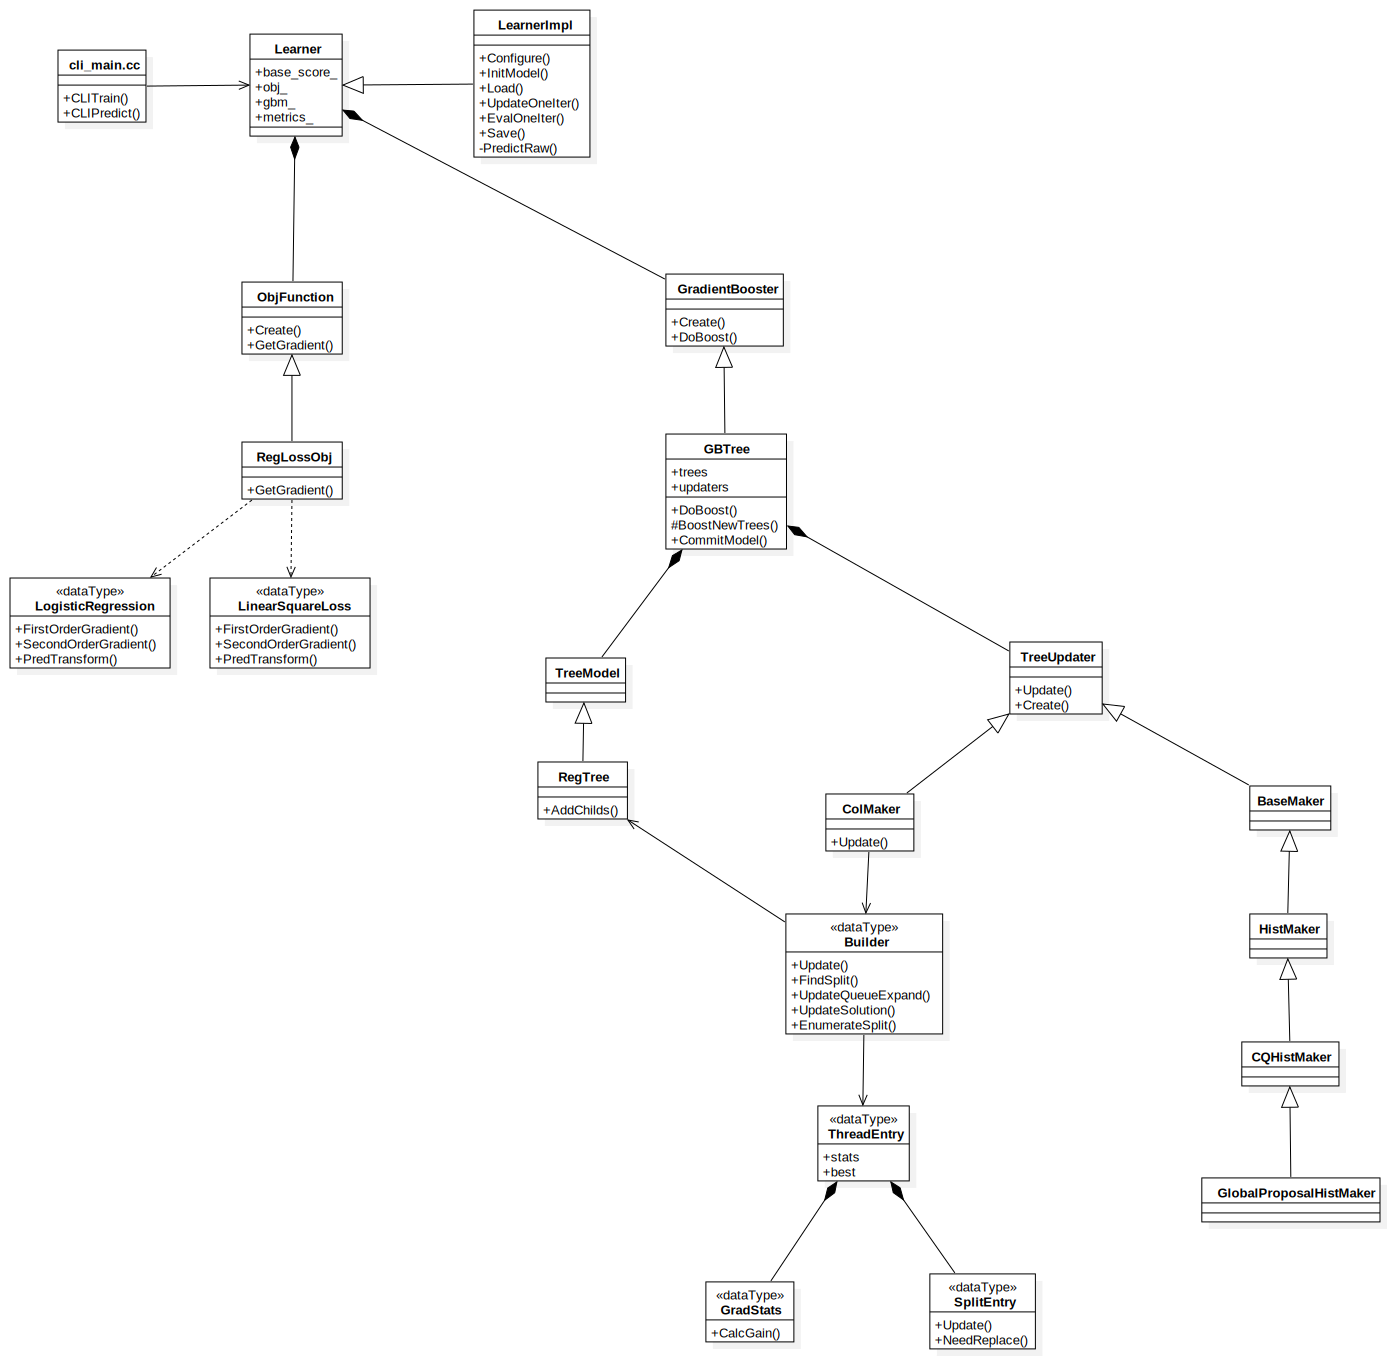

In [3]:
SVG("./res/Main.svg")